In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import math

In [25]:
df = pd.read_csv("./data/result_df/new_data_method2/concept_model_alt.csv",  index_col=0)

In [14]:
def calculate_fpr_tpr(df, threshold=0.75):
    true_positive = np.array([])
    true_negative = np.array([])

    false_positive = np.array([])
    false_negative = np.array([])

    for i in range(len(df)):
        if df.iloc[i]["cv_label"] == df.iloc[i]["job_label"]:
            if df.iloc[i]["similarity"] > threshold:
                true_positive = np.append(true_positive, df.iloc[i]["similarity"])
            else:
                false_negative = np.append(false_negative, df.iloc[i]["similarity"])
        else:
            if df.iloc[i]["similarity"] > threshold:
                false_positive = np.append(false_positive, df.iloc[i]["similarity"])
            else:
                true_negative = np.append(true_negative, df.iloc[i]["similarity"])
    
    # false positive rate FP / (FP + TN)
    fpr = len(false_positive) / (len(false_positive) + len(true_negative))

    # true positive rate TP / (TP + FN)
    tpr = len(true_positive) / (len(true_positive) + len(false_negative))


    return fpr, tpr

In [15]:
def generate_roc_curve(df, save_path="./data/roc_curve/", index='default', step=0.01):

    threshold_settings = np.arange(0, 1, step)

    fpr_arr = np.array([])
    tpr_arr = np.array([])

    # compute FP and TN for each threshold
    for threshold in tqdm(threshold_settings):
        fpr, tpr = calculate_fpr_tpr(df, threshold)
        fpr_arr = np.append(fpr_arr, fpr)
        tpr_arr = np.append(tpr_arr, tpr)
    
    # plot ROC curve
    fig, ax = plt.subplots()
    scatter = ax.scatter(fpr_arr, tpr_arr, 
                        c=threshold_settings,   # Use 'threshold' for color
                        cmap='hsv',        # Choose a colormap
                        label='Data Points')
    # plt.plot(fpr_arr, tpr_arr)

    # add labels
    cbar = plt.colorbar(scatter, label='Threshold')

    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")

    plt.savefig(
        os.path.join(save_path, f"{index}.png"),
        dpi=300,
    )
    plt.close()

    # save data
    pd.DataFrame({"threshold": threshold_settings, "fpr": fpr_arr, "tpr": tpr_arr}).to_csv(os.path.join(save_path, 'data', f"{index}.csv"),)
    

In [16]:
def generate_roc_curve_seperate(df, save_path="./data/roc_curve/", step=0.01):

    category_arr = df['cv_label'].unique()

    threshold_settings = np.arange(0, 1, step)

    fpr_arr = np.array([])
    tpr_arr = np.array([])

    # compute FP and TN for each threshold
    print("calculating FP and TN for each threshold...")
    with tqdm(total=len(category_arr) * len(threshold_settings)) as pbar:
        for category in category_arr:
            df_tmp = df[df['cv_label'] == category]
            for threshold in threshold_settings:
                fpr, tpr = calculate_fpr_tpr(df_tmp, threshold)
                fpr_arr = np.append(fpr_arr, fpr)
                tpr_arr = np.append(tpr_arr, tpr)
                pbar.update(1)
    
    # plot ROC curve
    print("plotting roc curves...")
    with tqdm(total=len(category_arr)) as pbar:
        for i in range(len(category_arr)):
            index = i*len(threshold_settings)

            fig, ax = plt.subplots()
            scatter = ax.scatter(fpr_arr[index:index+len(threshold_settings)], tpr_arr[index:index+len(threshold_settings)], 
                        c=threshold_settings,  # Use 'threshold' for color
                        cmap='hsv',  # Choose a colormap
                        label='Data Points')

            plt.xlabel("FP Rate")
            plt.ylabel("TP Rate")

            # add labels
            cbar = plt.colorbar(scatter, label='Threshold')

            plt.savefig(
                os.path.join(save_path, f"{category_arr[i]}.png"),
                dpi=300,
            )
            plt.close()

            # save data
            pd.DataFrame({
                "threshold": threshold_settings,
                "fpr": fpr_arr[index:index+len(threshold_settings)],
                "tpr": tpr_arr[index:index+len(threshold_settings)]
            }).to_csv(os.path.join(save_path, 'data', f"{category_arr[i]}.csv"),)

            pbar.update(1)
    
    # plot all ROC curves in one plot
    print("plotting all ROC curves in one plot...")

    # generate plot figure
    number_of_subplots = math.ceil(len(category_arr) / 5)
    fig, axes = plt.subplots(number_of_subplots, 5, figsize=(24, 8), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
    # Flatten the 2D array of axes for easier indexing
    axes = axes.flatten()

    with tqdm(total=len(category_arr)) as pbar:
        for i in range(len(category_arr)):
            index = i*len(threshold_settings)
            
            # plot subplot            
            scatter = axes[i].scatter(fpr_arr[index:index+len(threshold_settings)], tpr_arr[index:index+len(threshold_settings)], 
                            c=threshold_settings,
                            cmap='hsv',
                            label='Data Points')

            # set labels
            axes[i].text(0.5, -0.25, f'{chr(97 + i)}) {category_arr[i]}', fontsize=12, horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
            axes[i].set_xlabel('FP Rate')
            axes[i].set_ylabel('TP Rate')
         
            pbar.update(1)

    fig.subplots_adjust(right=0.87)
    cbar_ax = fig.add_axes([0.88, 0.12, 0.01, 0.76])
    fig.colorbar(scatter, cax=cbar_ax)

    plt.savefig(
        os.path.join(save_path, 'all_categories.png'),
        dpi=400,
    )
    plt.close()


In [26]:
generate_roc_curve(df, save_path='./data/roc_curve_method2/concept_model/', index='full_data', step=0.01)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
generate_roc_curve_seperate(df, save_path='./data/roc_curve_method2/concept_model/', step=0.01)

calculating FP and TN for each threshold...


  0%|          | 0/1000 [00:00<?, ?it/s]

plotting roc curves...


  0%|          | 0/10 [00:00<?, ?it/s]

plotting all ROC curves in one plot...


  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
tmp_df = pd.read_csv('./data/roc_curve/data/Blockchain.csv', index_col=0)

In [18]:
tmp_df

,threshold,fpr,tpr
0,0.00,1.0,1.0
1,0.01,1.0,1.0
2,0.02,1.0,1.0
3,0.03,1.0,1.0
4,0.04,1.0,1.0
...,...,...,...
95,0.95,0.0,0.0
96,0.96,0.0,0.0
97,0.97,0.0,0.0
98,0.98,0.0,0.0


In [19]:
fpr_arr = tmp_df['fpr'].values
tpr_arr = tmp_df['tpr'].values
threshold_settings = tmp_df['threshold'].values

In [20]:
index = 0

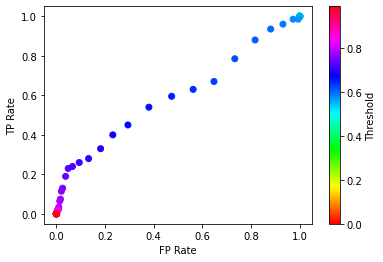

In [48]:
fig, ax = plt.subplots()
scatter = ax.scatter(fpr_arr[index:index+len(threshold_settings)], tpr_arr[index:index+len(threshold_settings)], 
            c=tmp_df['threshold'],  # Use 'threshold' for color
            cmap='hsv',  # Choose a colormap
            label='Data Points')

plt.xlabel("FP Rate")
plt.ylabel("TP Rate")

            # add labels
# for x in range(len(threshold_settings)):
#     ax.annotate(threshold_settings[x], (fpr_arr[index:index+x], tpr_arr[index:index+x]))

cbar = plt.colorbar(scatter, label='Threshold')

# Add legend
# legend = ax.legend(loc='upper right', title='Legend Title')
# legend.legendHandles[0]._sizes = [30]  # Adjust marker size in legend

plt.show()
# plt.savefig(
#     os.path.join(save_path, f"{category_arr[i]}.png"),
#     dpi=300,
# )
# plt.close()

In [49]:
import glob

In [65]:
files = [os.path.normpath(f) for f in glob.glob(os.path.join('./data/roc_curve/data', "*.csv"))]

In [66]:
category_arr = [os.path.basename(file).split('.')[0] for file in files]

  0%|          | 0/10 [00:00<?, ?it/s]

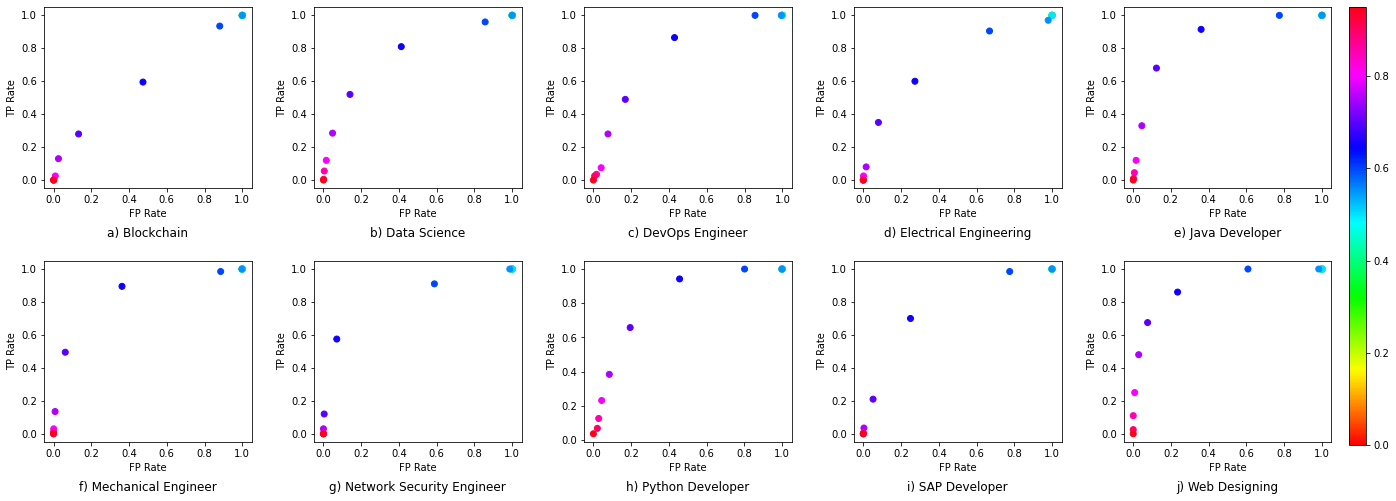

In [97]:
threshold_settings = np.arange(0, 1, 0.05)

# generate plot figure
number_of_subplots = math.ceil(len(category_arr) / 5)
fig, axes = plt.subplots(number_of_subplots, 5, figsize=(24, 8), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

with tqdm(total=len(files)) as pbar:
    for i in range(len(files)):
        index = i*len(threshold_settings)

        tmp_df = pd.read_csv(files[i], index_col=0)
            
        # plot subplot            
        scatter = axes[i].scatter(tmp_df['fpr'], tmp_df['tpr'], 
                                    c=tmp_df['threshold'],
                                    cmap='hsv',
                                    label='Data Points')

        # set labels
        axes[i].text(0.5, -0.25, f'{chr(97 + i)}) {category_arr[i]}', fontsize=12, horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_xlabel('FP Rate')
        axes[i].set_ylabel('TP Rate')
            
        pbar.update(1)

fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.88, 0.12, 0.01, 0.76])
fig.colorbar(scatter, cax=cbar_ax)